In [60]:
# from tesserocr import get_languages, PyTessBaseAPI
import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests
import base64
import bs4
from concurrent.futures import ThreadPoolExecutor
# import matplotlib.pyplot as plt

# print(get_languages('C:/Programs/tessdata'))

In [1]:


def get_captcha(filename):
    url = "https://service2.diplo.de/rktermin/extern/appointment_refreshCaptchamonth.do"
    data = {
        "action:appointment_refreshCaptchamonth": "Neues Bild laden",
        "locationCode": "amst",
        "realmId": 1113,
        "categoryId": 2662
    }
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36",
    }
    try:
        response = requests.post(url, data, headers=headers)
        soup = bs4.BeautifulSoup(response.text, "html.parser")
        # get captcha name tag
        captcha_div = soup.find("captcha").find("div")
        # get style of captcha_div
        style = captcha_div.attrs["style"]
        b64 = style.split(",")[1].split("')")[0]
        byt = base64.b64decode(b64)
        # show captcha image
        img = cv2.imdecode(np.frombuffer(byt, np.uint8), cv2.IMREAD_COLOR)
        # save image in captcha folder
        cv2.imwrite(filename, img)
    except Exception as e:
        print(e)





In [6]:
with ThreadPoolExecutor(max_workers=10) as executor:
    for i in range(20):
        executor.submit(get_captcha, f"captcha/untagged/{i}.jpg")


In [22]:
from PIL import Image
from pathlib import Path


data_dir = Path("./captcha/")
for file in data_dir.glob("*.jpg"):
    im = Image.open(file)
    im.save(file.with_suffix(".png"))


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2023-03-22 18:51:47.096409: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 18:51:48.714947: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/anaconda3/2022.10/envs/rk-termin/lib/
2023-03-22 18:51:48.715054: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/anaconda3/2022.10/envs/rk-termin/lib/
2023-03-22 18:51:48.715062: W tensorflow/c

In [1]:
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
!unzip -qq captcha_images_v2.zip

/bin/bash: /opt/anaconda3/2022.10/envs/rk-termin/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 8863k  100 8863k    0     0  3842k      0  0:00:02  0:00:02 --:--:-- 6907k
/bin/bash: /opt/anaconda3/2022.10/envs/rk-termin/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [51]:
# # Path to the data directory
# data_dir = Path("./captcha_images_v2/")

# # Get list of all the images
# images = sorted(list(map(str, list(data_dir.glob("*.png")))))
# labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]

# Path to the data directory
data_dir = Path("./captcha/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]


characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 300
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])
min_length = min([len(label) for label in labels])
print("Maximum length of a label: ", max_length)
print("Minimum length of a label: ", min_length)

Number of images found:  255
Number of labels found:  255
Number of unique characters:  23
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'o', 'p', 'v', 'w', 'x', 'y', 'z']
Maximum length of a label:  6
Minimum length of a label:  6


In [52]:
# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [53]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

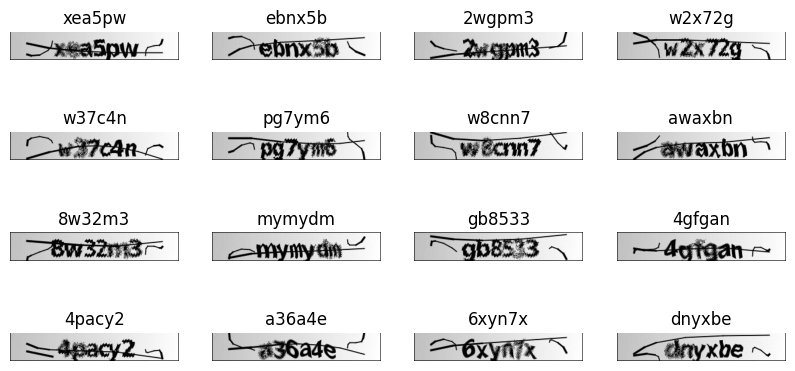

In [54]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [55]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


In [56]:
# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 300, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 300, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 150, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 150, 25, 64)  18496       ['pool1[0][0]']       

In [ ]:
from sklearn.model_selection import KFold

epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)
# k fold cross validation
kfold = KFold(n_splits=10, shuffle=True)
for train, test in kfold.split(x_train, y_train):
    model.fit(x_train[train], y_train[train], epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=1)
    scores = model.evaluate(x_train[test], y_train[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# Save the model to disk
model.save("ocr_model.h5")

In [57]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)



Epoch 1/100
15/15 [==============================] - 8s 204ms/step - loss: 48.3829 - val_loss: 23.2900
Epoch 2/100
15/15 [==============================] - 1s 97ms/step - loss: 21.0475 - val_loss: 20.4797
Epoch 3/100
15/15 [==============================] - 1s 85ms/step - loss: 20.0916 - val_loss: 20.2391
Epoch 4/100
15/15 [==============================] - 1s 91ms/step - loss: 19.9034 - val_loss: 20.2020
Epoch 5/100
15/15 [==============================] - 1s 88ms/step - loss: 19.8265 - val_loss: 20.1103
Epoch 6/100
15/15 [==============================] - 1s 88ms/step - loss: 19.7909 - val_loss: 20.0733
Epoch 7/100
15/15 [==============================] - 1s 88ms/step - loss: 19.7687 - val_loss: 20.0406
Epoch 8/100
15/15 [==============================] - 1s 86ms/step - loss: 19.7515 - val_loss: 20.0164
Epoch 9/100
15/15 [==============================] - 1s 90ms/step - loss: 19.7367 - val_loss: 20.0021
Epoch 10/100
15/15 [==============================] - 1s 87ms/step - loss: 19.733

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 300, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 300, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 150, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 150, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 75, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 75, 768)           0         
                                                                 
 dense1 (Dense)              (None, 75, 64)            492

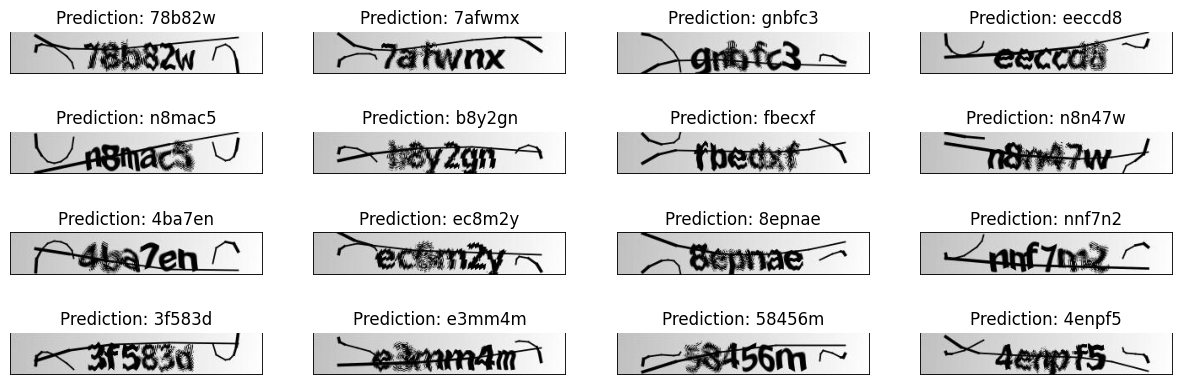

1/1 [==============================] - 2s 2s/step


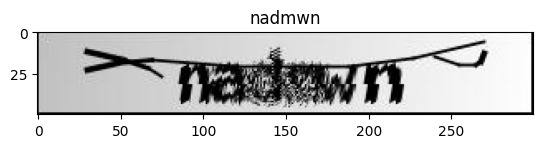

In [67]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()


def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img / 255.0
    # swap axis
    img = np.swapaxes(img, 0, 1)
    img = np.expand_dims(img, axis=2)
    return img

# function to predict the text from one image
def predict(img):
    img = preprocess_image(img)
    img = tf.expand_dims(img, 0)
    pred = prediction_model.predict(img)
    pred_text = decode_batch_predictions(pred)
    return pred_text[0]

predicted_text = predict(cv2.imread("./82.jpg", cv2.IMREAD_COLOR))
# plot the image
plt.imshow(cv2.imread("./82.jpg", cv2.IMREAD_COLOR))
plt.title(predicted_text)
plt.show()



In [68]:
# save the model
model.save("ocr_model.h5")